<a href="https://colab.research.google.com/github/HechengJin0/MGCX/blob/master/k_mean_monkey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# start

In [ ]:
!pip install brainspace
!pip install cifti
!pip install graspy
!pip install nibabel==3.0.1
!pip install nilearn
!pip install nipype
# !pip uninstall ipykernel
# !pip install ipykernel==4.10.0

     |████████████████████████████████| 60.7MB 1.3MB/s eta 0:00:01
ERROR: Operation cancelled by user
Exception ignored in: <function _get_module_lock.<locals>.cb at 0x7f31b23e7b70>
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 177, in cb
KeyboardInterrupt: 
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.main import main
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/main.py", line 13, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/autocompletion.py", line 11, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/main_parser.py", line 7, in <module>
    from pip._internal.cli import cmdoptions
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/cmdoptions.py", line 28, in <module>
    from

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:

import numpy as np
from joblib import Parallel, delayed
import sys
import nibabel as nib
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from statistics import mean

import scipy
from scipy.stats import pearsonr, zscore

import graspy as gp
from graspy.plot import heatmap
import pandas as pd
from scipy.stats import pearsonr, zscore, spearmanr
from statistics import mean 

import graspy as gp
from graspy.plot import heatmap
import cifti
from nilearn import surface
from nilearn import plotting

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ModuleNotFoundError: ignored

# load data

In [ ]:
# 06/04 all roi
# z-score

# Parameters.	  
M = 0   
tr = 240

# data paths
isolevel = '000' ##Change this to get the different levels of isoflourine
data_cat = []
for ses_i in range(2): # select the first session for the purpose of testing
  pt_paths = np.loadtxt('/gdrive/My Drive/CMI/Project/MGCX/NHP/data/info/Anes%s_reduced_10K_3mm_pt_wVol_paths.txt' % (isolevel),dtype='str', delimiter= '\n') 
  ptfile = pt_paths[ses_i]
  ptfile_new = ptfile.replace('dtseries','MarkovCC12_M132_182-area.10k_fs_LR.dlabel.ptseries') # aim to do not touch original path file

  img = nib.load('/gdrive/My Drive/CMI/Project/MGCX/NHP/data/10k_Markov182/10k_Markov182%s' % ptfile_new)
  data_ses = np.array(img.get_fdata())
  
  axis= 0
  data_ses_zscore = zscore(data_ses,axis=axis) #z-score: across tr parcel mean 0	
  data_cat.append(data_ses_zscore)

data = np.vstack(data_cat)  

## run k-mean


In [ ]:
data.shape

(480, 182)

In [ ]:
n_clusters = 6
km = TimeSeriesKMeans_HJ(n_clusters=n_clusters, metric="correlation", max_iter=5,random_state=0)
km.fit(data)
centroids = km.cluster_centers_
labels = km.fit_predict(data)

# calculate individual CAP
cap_append = []
Z_append = []
avg_voxel_append = []
for i in range(n_clusters):
  cluster_mask = np.where(labels == i)
  # fMRI frames assigned to each cluster were averaged voxel-wise
  avg_voxel= np.mean(data[cluster_mask],axis=0)
  # normalized to T-scores (p < 0.01, Bonferroni corrected)
  # z-score
  Z = zscore(avg_voxel)
  # convert z to t 
  T = np.array(Z) * 10 + 50   # not correct
  cap_append.append(T)
  Z_append.append(Z) # not neccessary, just test
  avg_voxel_append.append(avg_voxel) # not neccessary, just test

# cap_all = np.vstack(cap_append)  
Z_all = np.vstack(Z_append) 
avg_voxel_all = np.vstack(avg_voxel_append) 

In [ ]:
df = data
from scipy.spatial.distance import cdist, pdist
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans


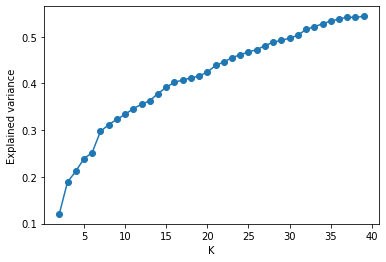

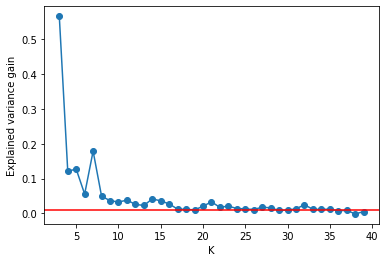

In [ ]:


def elbow(df, n):
    from scipy.spatial.distance import cdist, pdist
    kMeansVar = [TimeSeriesKMeans_HJ(n_clusters=k,metric="correlation",max_iter=5,random_state=0).fit(df) for k in range(2,n)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    # calculate the Euclidean distance from each point to each cluster center
    k_euclid = [cdist(df, cent.reshape(cent_num+2,182)) for cent_num,cent in enumerate(centroids)]
    dist = [np.min(ke, axis=1) for ke in k_euclid]

    # total within cluster sum of squares
    wcss = [sum(d**2) for d in dist ]
    # total sum of squares
    tss = sum(pdist(df)**2)/df.shape[0] 
    # https://math.stackexchange.com/questions/1009297/variances-for-k-means-clustering
    bss = tss-wcss
    explained_variance = bss/tss
    plt.plot(range(2,n),explained_variance, '-o')
    plt.xlabel('K')
    plt.ylabel('Explained variance')
    plt.show()

    # Percentage gain in variance explained when advancing from k-1 to k.
    gain = [(explained_variance[i+1]- explained_variance[i])/(explained_variance[i]) for i in range(0,len(bss)-1)]
    plt.plot(range(3,n),gain, '-o') # range (3,n), since gain is from k-1 to k
    plt.axhline(y=0.01, color='r', linestyle='-')
    plt.xlabel('K')
    plt.ylabel('Explained variance gain')
    plt.show()

elbow(data, 40)

# Between-cluster variance was computed as the averaged square distance between a cluster centroid and the centroid of all clusters or centroid of all data

In [ ]:
bss

NameError: ignored

## K-means clustering function

In [ ]:
!pip install tslearn

     |████████████████████████████████| 778kB 2.7MB/s 


### func: k-init correlation_distances

In [ ]:
# https://github.com/scikit-learn/scikit-learn/blob/b0c03d128007bd264e0e2b82e14c123a51f22308/sklearn/cluster/_kmeans.py

from sklearn.metrics import pairwise_distances 
import scipy.sparse as sp

def correlation_distances(X, Y, n_jobs=None):
    return pairwise_distances(X, Y, metric="correlation", n_jobs=n_jobs)

# modify-HJ: euclidean_distances -> correlation_distances
def _k_init(X, n_clusters, x_squared_norms, random_state, n_local_trials=None):
    """Init n_clusters seeds according to k-means++
    Parameters
    ----------
    X : {ndarray, sparse matrix} of shape (n_samples, n_features)
        The data to pick seeds for. To avoid memory copy, the input data
        should be double precision (dtype=np.float64).
    n_clusters : int
        The number of seeds to choose
    x_squared_norms : ndarray of shape (n_samples,)
        Squared Euclidean norm of each data point.
    random_state : RandomState instance
        The generator used to initialize the centers.
        See :term:`Glossary <random_state>`.
    n_local_trials : int, default=None
        The number of seeding trials for each center (except the first),
        of which the one reducing inertia the most is greedily chosen.
        Set to None to make the number of trials depend logarithmically
        on the number of seeds (2+log(k)); this is the default.
    Notes
    -----
    Selects initial cluster centers for k-mean clustering in a smart way
    to speed up convergence. see: Arthur, D. and Vassilvitskii, S.
    "k-means++: the advantages of careful seeding". ACM-SIAM symposium
    on Discrete algorithms. 2007
    Version ported from http://www.stanford.edu/~darthur/kMeansppTest.zip,
    which is the implementation used in the aforementioned paper.
    """
    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)
    
    # modify-HJ : this line can comment, since we don't use Euclidean
    # assert x_squared_norms is not None, 'x_squared_norms None in _k_init'

    # Set the number of local seeding trials if none is given
    if n_local_trials is None:
        # This is what Arthur/Vassilvitskii tried, but did not report
        # specific results for other than mentioning in the conclusion
        # that it helped.
        n_local_trials = 2 + int(np.log(n_clusters))

    # Pick first center randomly
    center_id = random_state.randint(n_samples)
    if sp.issparse(X):
        centers[0] = X[center_id].toarray()
    else:
        centers[0] = X[center_id]

    # Initialize list of closest distances and calculate current potential
    # modify-HJ: euclidean_distances -> correlation_distances

    # closest_dist_sq = euclidean_distances(
    #     centers[0, np.newaxis], X, Y_norm_squared=x_squared_norms,
    #     squared=True)
    closest_dist_sq = correlation_distances(centers[0, np.newaxis], X)

    current_pot = closest_dist_sq.sum()

    # Pick the remaining n_clusters-1 points
    for c in range(1, n_clusters):
        # Choose center candidates by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_vals = random_state.random_sample(n_local_trials) * current_pot
        candidate_ids = np.searchsorted(stable_cumsum(closest_dist_sq),
                                        rand_vals)
        # XXX: numerical imprecision can result in a candidate_id out of range
        np.clip(candidate_ids, None, closest_dist_sq.size - 1,
                out=candidate_ids)

        # Compute distances to center candidates
        # modify-HJ: euclidean_distances -> correlation_distances

        # distance_to_candidates = correlation_distances(
        #     X[candidate_ids], X, Y_norm_squared=x_squared_norms, squared=True)
        distance_to_candidates = correlation_distances(X[candidate_ids], X)

        # update closest distances squared and potential for each candidate
        np.minimum(closest_dist_sq, distance_to_candidates,
                   out=distance_to_candidates)
        candidates_pot = distance_to_candidates.sum(axis=1)

        # Decide which candidate is the best
        best_candidate = np.argmin(candidates_pot)
        current_pot = candidates_pot[best_candidate]
        closest_dist_sq = distance_to_candidates[best_candidate]
        best_candidate = candidate_ids[best_candidate]

        # Permanently add best center candidate found in local tries
        if sp.issparse(X):
            centers[c] = X[best_candidate].toarray()
        else:
            centers[c] = X[best_candidate]

    return centers

### TimeSeriesKmeans

In [ ]:
# https://github.com/tslearn-team/tslearn/blob/775dadd/tslearn/clustering.py#L671-L1059 

from tslearn.utils import (to_time_series_dataset, to_time_series,
                           to_sklearn_dataset, check_dims)
from sklearn.utils import check_random_state
from sklearn.base import ClusterMixin, TransformerMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics.cluster import \
    silhouette_score as sklearn_silhouette_score
from sklearn.utils import check_random_state
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import _check_sample_weight
from scipy.spatial.distance import cdist
import numpy
import warnings

from tslearn.metrics import cdist_gak, cdist_dtw, cdist_soft_dtw, \
    cdist_soft_dtw_normalized, sigma_gak
from tslearn.barycenters import euclidean_barycenter, \
    dtw_barycenter_averaging, softdtw_barycenter
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import (to_time_series_dataset, to_time_series,
                           to_sklearn_dataset, check_dims)
from tslearn.cycc import cdist_normalized_cc, y_shifted_sbd_vec
from tslearn.bases import BaseModelPackage, TimeSeriesBaseEstimator
def _check_initial_guess(init, n_clusters):
    if hasattr(init, '__array__'):
        assert init.shape[0] == n_clusters, \
            "Initial guess index array must contain {} samples," \
            " {} given".format(n_clusters, init.shape[0])
class EmptyClusterError(Exception):
    def __init__(self, message=""):
        super().__init__()
        self.message = message

    def __str__(self):
        if len(self.message) > 0:
            suffix = " (%s)" % self.message
        else:
            suffix = ""
        return "Cluster assignments lead to at least one empty cluster" + \
               suffix
def _check_full_length(centroids):
    """Check that provided centroids are full-length (ie. not padded with
    nans).
    If some centroids are found to be padded with nans, TimeSeriesResampler is
    used to resample the centroids.
    """
    resampler = TimeSeriesResampler(sz=centroids.shape[1])
    return resampler.fit_transform(centroids)
def _check_no_empty_cluster(labels, n_clusters):
    """Check that all clusters have at least one sample assigned.
    """

    for k in range(n_clusters):
        if numpy.sum(labels == k) == 0:
            raise EmptyClusterError

def _compute_inertia(distances, assignments, squared=True):
    """Derive inertia (average of squared distances) from pre-computed
    distances and assignments.
    Examples
    --------
    >>> dists = numpy.array([[1., 2., 0.5], [0., 3., 1.]])
    >>> assign = numpy.array([2, 0])
    >>> _compute_inertia(dists, assign)
    0.125
    """
    n_ts = distances.shape[0]
    if squared:
        return numpy.sum(distances[numpy.arange(n_ts),
                                   assignments] ** 2) / n_ts
    else:
        return numpy.sum(distances[numpy.arange(n_ts), assignments]) / n_ts

class TimeSeriesCentroidBasedClusteringMixin:
    """Mixin class for centroid-based clustering of time series."""
    def _post_fit(self, X_fitted, centroids, inertia):
        if numpy.isfinite(inertia) and (centroids is not None):
            self.cluster_centers_ = centroids
            self._assign(X_fitted)
            self._X_fit = X_fitted
            self.inertia_ = inertia
        else:
            self._X_fit = None

class TimeSeriesKMeans_HJ(TransformerMixin, ClusterMixin,
                       TimeSeriesCentroidBasedClusteringMixin,
                       BaseModelPackage, TimeSeriesBaseEstimator):
    """K-means clustering for time-series data.
    Parameters
    ----------
    n_clusters : int (default: 3)
        Number of clusters to form.
    max_iter : int (default: 50)
        Maximum number of iterations of the k-means algorithm for a single run.
    tol : float (default: 1e-6)
        Inertia variation threshold. If at some point, inertia varies less than
        this threshold between two consecutive
        iterations, the model is considered to have converged and the algorithm
        stops.
    n_init : int (default: 1)
        Number of time the k-means algorithm will be run with different
        centroid seeds. The final results will be the best output of n_init
        consecutive runs in terms of inertia.
    metric : {"euclidean", "dtw", "softdtw"} (default: "euclidean")
        Metric to be used for both cluster assignment and barycenter
        computation. If "dtw", DBA is used for barycenter
        computation.
    max_iter_barycenter : int (default: 100)
        Number of iterations for the barycenter computation process. Only used
        if `metric="dtw"` or `metric="softdtw"`.
    metric_params : dict or None (default: None)
        Parameter values for the chosen metric.
        For metrics that accept parallelization of the cross-distance matrix
        computations, `n_jobs` key passed in `metric_params` is overridden by
        the `n_jobs` argument.
    n_jobs : int or None, optional (default=None)
        The number of jobs to run in parallel for cross-distance matrix
        computations.
        Ignored if the cross-distance matrix cannot be computed using
        parallelization.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See scikit-learns'
        `Glossary <https://scikit-learn.org/stable/glossary.html#term-n-jobs>`_
        for more details.
    dtw_inertia: bool (default: False)
        Whether to compute DTW inertia even if DTW is not the chosen metric.
    verbose : int (default: 0)
        If nonzero, print information about the inertia while learning
        the model and joblib progress messages are printed.  
    random_state : integer or numpy.RandomState, optional
        Generator used to initialize the centers. If an integer is given, it
        fixes the seed. Defaults to the global
        numpy random number generator.
    init : {'k-means++', 'random' or an ndarray} (default: 'k-means++')
        Method for initialization:
        'k-means++' : use k-means++ heuristic. See `scikit-learn's k_init_
        <https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/\
        cluster/k_means_.py>`_ for more.
        'random': choose k observations (rows) at random from data for the
        initial centroids.
        If an ndarray is passed, it should be of shape (n_clusters, ts_size, d)
        and gives the initial centers.
    Attributes
    ----------
    labels_ : numpy.ndarray
        Labels of each point.
    cluster_centers_ : numpy.ndarray of shape (n_clusters, sz, d)
        Cluster centers.
        `sz` is the size of the time series used at fit time if the init method
        is 'k-means++' or 'random', and the size of the longest initial
        centroid if those are provided as a numpy array through init parameter.
    inertia_ : float
        Sum of distances of samples to their closest cluster center.
    n_iter_ : int
        The number of iterations performed during fit.
    Notes
    -----
        If `metric` is set to `"euclidean"`, the algorithm expects a dataset of
        equal-sized time series.
    Examples
    --------
    >>> from tslearn.generators import random_walks
    >>> X = random_walks(n_ts=50, sz=32, d=1)
    >>> km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5,
    ...                       random_state=0).fit(X)
    >>> km.cluster_centers_.shape
    (3, 32, 1)
    >>> km_dba = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5,
    ...                           max_iter_barycenter=5,
    ...                           random_state=0).fit(X)
    >>> km_dba.cluster_centers_.shape
    (3, 32, 1)
    >>> km_sdtw = TimeSeriesKMeans(n_clusters=3, metric="softdtw", max_iter=5,
    ...                            max_iter_barycenter=5,
    ...                            metric_params={"gamma": .5},
    ...                            random_state=0).fit(X)
    >>> km_sdtw.cluster_centers_.shape
    (3, 32, 1)
    >>> X_bis = to_time_series_dataset([[1, 2, 3, 4],
    ...                                 [1, 2, 3],
    ...                                 [2, 5, 6, 7, 8, 9]])
    >>> km = TimeSeriesKMeans(n_clusters=2, max_iter=5,
    ...                       metric="dtw", random_state=0).fit(X_bis)
    >>> km.cluster_centers_.shape
    (2, 6, 1)
    """

    def __init__(self, n_clusters=3, max_iter=50, tol=1e-6, n_init=1,
                 metric="euclidean", max_iter_barycenter=100,
                 metric_params=None, n_jobs=None, dtw_inertia=False,
                 verbose=0, random_state=None, init='k-means++'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.n_init = n_init
        self.metric = metric
        self.max_iter_barycenter = max_iter_barycenter
        self.metric_params = metric_params
        self.n_jobs = n_jobs
        self.dtw_inertia = dtw_inertia
        self.verbose = verbose
        self.random_state = random_state
        self.init = init

    def _is_fitted(self):
        check_is_fitted(self, ['cluster_centers_'])
        return True

    def _get_metric_params(self):
        if self.metric_params is None:
            metric_params = {}
        else:
            metric_params = self.metric_params.copy()
        if "n_jobs" in metric_params.keys():
            del metric_params["n_jobs"]
        return metric_params

    def _fit_one_init(self, X, x_squared_norms, rs):
        metric_params = self._get_metric_params()
        n_ts, sz, d = X.shape
        if hasattr(self.init, '__array__'):
            self.cluster_centers_ = self.init.copy()
        elif self.init == "k-means++":
            # modify-HJ : add 'correlation' metric 
            if self.metric == "correlation":  #self.metric == "euclidean"  modified _k_init : "euclidean"-> "correlation"
                self.cluster_centers_ = _k_init(
                    X.reshape((n_ts, -1)),
                    self.n_clusters,
                    x_squared_norms,
                    rs
                ).reshape((-1, sz, d))
            else:
                if self.metric == "dtw":
                    def metric_fun(x, y):
                        return cdist_dtw(x, y, n_jobs=self.n_jobs,
                                         verbose=self.verbose, **metric_params)

                elif self.metric == "softdtw":
                    def metric_fun(x, y):
                        return cdist_soft_dtw(x, y, **metric_params)
                else:
                    raise ValueError(
                        "Incorrect metric: %s (should be one of 'dtw', "
                        "'softdtw', 'euclidean')" % self.metric
                    )
                self.cluster_centers_ = _k_init_metric(X, self.n_clusters,
                                                       cdist_metric=metric_fun,
                                                       random_state=rs)
        elif self.init == "random":
            indices = rs.choice(X.shape[0], self.n_clusters)
            self.cluster_centers_ = X[indices].copy()
        else:
            raise ValueError("Value %r for parameter 'init'"
                             "is invalid" % self.init)
        self.cluster_centers_ = _check_full_length(self.cluster_centers_)
        old_inertia = numpy.inf

        for it in range(self.max_iter):
            self._assign(X)
            if self.verbose:
                print("%.3f" % self.inertia_, end=" --> ")
            self._update_centroids(X)

            if numpy.abs(old_inertia - self.inertia_) < self.tol:
                break
            old_inertia = self.inertia_
        if self.verbose:
            print("")

        self._iter = it + 1

        return self

    def _transform(self, X):
        metric_params = self._get_metric_params()
        if self.metric == "euclidean":
            return cdist(X.reshape((X.shape[0], -1)),
                          self.cluster_centers_.reshape((self.n_clusters, -1)),
                          metric="euclidean")
        elif self.metric == "correlation":
            return cdist(X.reshape((X.shape[0], -1)),
                          self.cluster_centers_.reshape((self.n_clusters, -1)),
                          metric="correlation") 
        elif self.metric == "dtw":
            return cdist_dtw(X, self.cluster_centers_, n_jobs=self.n_jobs,
                              verbose=self.verbose, **metric_params)
        elif self.metric == "softdtw":
            return cdist_soft_dtw(X, self.cluster_centers_, **metric_params)
        else:
            raise ValueError("Incorrect metric: %s (should be one of 'dtw', "
                             "'softdtw', 'euclidean')" % self.metric)

    def _assign(self, X, update_class_attributes=True):
        dists = self._transform(X)
        matched_labels = dists.argmin(axis=1)
        if update_class_attributes:
            self.labels_ = matched_labels
            _check_no_empty_cluster(self.labels_, self.n_clusters)
            if self.dtw_inertia and self.metric != "dtw":
                inertia_dists = cdist_dtw(X, self.cluster_centers_,
                                          n_jobs=self.n_jobs,
                                          verbose=self.verbose)
            else:
                inertia_dists = dists
            self.inertia_ = _compute_inertia(inertia_dists,
                                             self.labels_,
                                             self._squared_inertia)
        return matched_labels

    def _update_centroids(self, X):
        metric_params = self._get_metric_params()
        for k in range(self.n_clusters):
            if self.metric == "dtw":
                self.cluster_centers_[k] = dtw_barycenter_averaging(
                    X=X[self.labels_ == k],
                    barycenter_size=None,
                    init_barycenter=self.cluster_centers_[k],
                    metric_params=metric_params,
                    verbose=False)
            elif self.metric == "softdtw":
                self.cluster_centers_[k] = softdtw_barycenter(
                    X=X[self.labels_ == k],
                    max_iter=self.max_iter_barycenter,
                    init=self.cluster_centers_[k],
                    **metric_params)
            # modify-HJ: "correlation" can also use np.mean same as euclidean_barycenter
            else: 
                self.cluster_centers_[k] = euclidean_barycenter(
                    X=X[self.labels_ == k]) 

    def fit(self, X, y=None):
        """Compute k-means clustering.
        Parameters
        ----------
        X : array-like of shape=(n_ts, sz, d)
            Time series dataset.
        y
            Ignored
        """

        X = check_array(X, allow_nd=True, force_all_finite='allow-nan')

        if hasattr(self.init, '__array__'):
            X = check_dims(X, X_fit_dims=self.init.shape,
                           extend=True,
                           check_n_features_only=(self.metric != "euclidean"))


        self.labels_ = None
        self.inertia_ = numpy.inf
        self.cluster_centers_ = None
        self._X_fit = None
        self._squared_inertia = True

        self.n_iter_ = 0

        max_attempts = max(self.n_init, 10)

        X_ = to_time_series_dataset(X)
        rs = check_random_state(self.random_state)

        if self.init == "k-means++" and self.metric == "euclidean":
            n_ts, sz, d = X_.shape
            x_squared_norms = cdist(X_.reshape((n_ts, -1)),
                                    numpy.zeros((1, sz * d)),
                                    metric="sqeuclidean").reshape((1, -1))
        else:
            x_squared_norms = None
        _check_initial_guess(self.init, self.n_clusters)

        best_correct_centroids = None
        min_inertia = numpy.inf
        n_successful = 0
        n_attempts = 0
        while n_successful < self.n_init and n_attempts < max_attempts:
            try:
                if self.verbose and self.n_init > 1:
                    print("Init %d" % (n_successful + 1))
                n_attempts += 1
                self._fit_one_init(X_, x_squared_norms, rs)
                if self.inertia_ < min_inertia:
                    best_correct_centroids = self.cluster_centers_.copy()
                    min_inertia = self.inertia_
                    self.n_iter_ = self._iter
                n_successful += 1
            except EmptyClusterError:
                if self.verbose:
                    print("Resumed because of empty cluster")
        self._post_fit(X_, best_correct_centroids, min_inertia)
        return self

    def fit_predict(self, X, y=None):
        """Fit k-means clustering using X and then predict the closest cluster
        each time series in X belongs to.
        It is more efficient to use this method than to sequentially call fit
        and predict.
        Parameters
        ----------
        X : array-like of shape=(n_ts, sz, d)
            Time series dataset to predict.
        y
            Ignored
        Returns
        -------
        labels : array of shape=(n_ts, )
            Index of the cluster each sample belongs to.
        """
        X = check_array(X, allow_nd=True, force_all_finite='allow-nan')
        return self.fit(X, y).labels_

    def predict(self, X):
        """Predict the closest cluster each time series in X belongs to.
        Parameters
        ----------
        X : array-like of shape=(n_ts, sz, d)
            Time series dataset to predict.
        Returns
        -------
        labels : array of shape=(n_ts, )
            Index of the cluster each sample belongs to.
        """
        X = check_array(X, allow_nd=True, force_all_finite='allow-nan')
        check_is_fitted(self, 'cluster_centers_')
        X = check_dims(X, X_fit_dims=self.cluster_centers_.shape,
                       extend=True,
                       check_n_features_only=(self.metric != "euclidean"))
        return self._assign(X, update_class_attributes=False)

    def transform(self, X):
        """Transform X to a cluster-distance space.
        
        In the new space, each dimension is the distance to the cluster 
        centers.
        Parameters
        ----------
        X : array-like of shape=(n_ts, sz, d)
            Time series dataset
        Returns
        -------
        distances : array of shape=(n_ts, n_clusters)
            Distances to cluster centers
        """
        X = check_array(X, allow_nd=True, force_all_finite='allow-nan')
        check_is_fitted(self, 'cluster_centers_')
        X = check_dims(X, X_fit_dims=self.cluster_centers_.shape,
                       extend=True,
                       check_n_features_only=(self.metric != "euclidean"))
        return self._transform(X)

    def _more_tags(self):
        return {'allow_nan': True, 'allow_variable_length': True}

# plot homo

## parcel2vert func

In [ ]:
from nilearn import surface
from nilearn import plotting
wdir = '/gdrive/My Drive/CMI/Project/MGCX/NHP'
lsurf = surface.load_surf_mesh('%s/fsaverage_LR10k/MAJOM.L.inflated.10k_fs_LR.surf.gii' % wdir)
rsurf = surface.load_surf_mesh('%s/fsaverage_LR10k/MAJOM.R.inflated.10k_fs_LR.surf.gii' % wdir)
rightsurface = '%s/fsaverage_LR10k/MAJOM.R.inflated.10k_fs_LR.surf.gii' % wdir
leftsurface = '%s/fsaverage_LR10k/MAJOM.L.inflated.10k_fs_LR.surf.gii' % wdir
# parcel_label = plabel = '%s/data/10k_Bezgin/Bezgin_RM.10k_fs_LR.dlabel.nii' % wdir


def parcel2vert_all(wdir,lsurf,plabel,theta_img):
    glasserlabel,(ax1,ax2) = cifti.read(plabel)
    numverts = int(glasserlabel.shape[1])
    if len(theta_img.shape) >1:
        numparcels = len(theta_img)
    else:
        numparcels = 1
        theta_img = np.reshape(theta_img,[-1,len(theta_img)])
    nparc = np.arange(numparcels)
    data = np.zeros([numparcels,numverts])
    for parcel in nparc:
        for plabel in range(int(np.max((glasserlabel)))):
            p_idx = np.where(glasserlabel[0,:]==plabel+1)
            data[parcel,p_idx] = theta_img[parcel,plabel]
    return data 

def parcel2vert_bezgin_label(wdir,lsurf,plabel,theta_img):
    glasserlabel,(ax1,ax2) = cifti.read(plabel)
    numverts = int(glasserlabel.shape[1]/2)
    if len(theta_img.shape) >1:
        numparcels = len(theta_img)
    else:
        numparcels = 1
        theta_img = np.reshape(theta_img,[-1,len(theta_img)])
    nparc = np.arange(numparcels)
    data = np.zeros([numparcels,numverts])
    for parcel in nparc:
      for plabel in range(int(np.max((glasserlabel)))):  # np.max((glasserlabel) = 685, somehow it is wired. 
        p_idx = np.where(glasserlabel[0,:]==plabel+1)
        # data[parcel,p_idx] = theta_img[parcel,plabel]
        j = int(glasserlabel.shape[1]/2)
        p_idx_new = tuple(map(lambda i: i-j, p_idx))
        #plabel = plabel-180
        plabel = plabel-8897
        data[parcel,p_idx_new] = theta_img[parcel,plabel]
    return data 




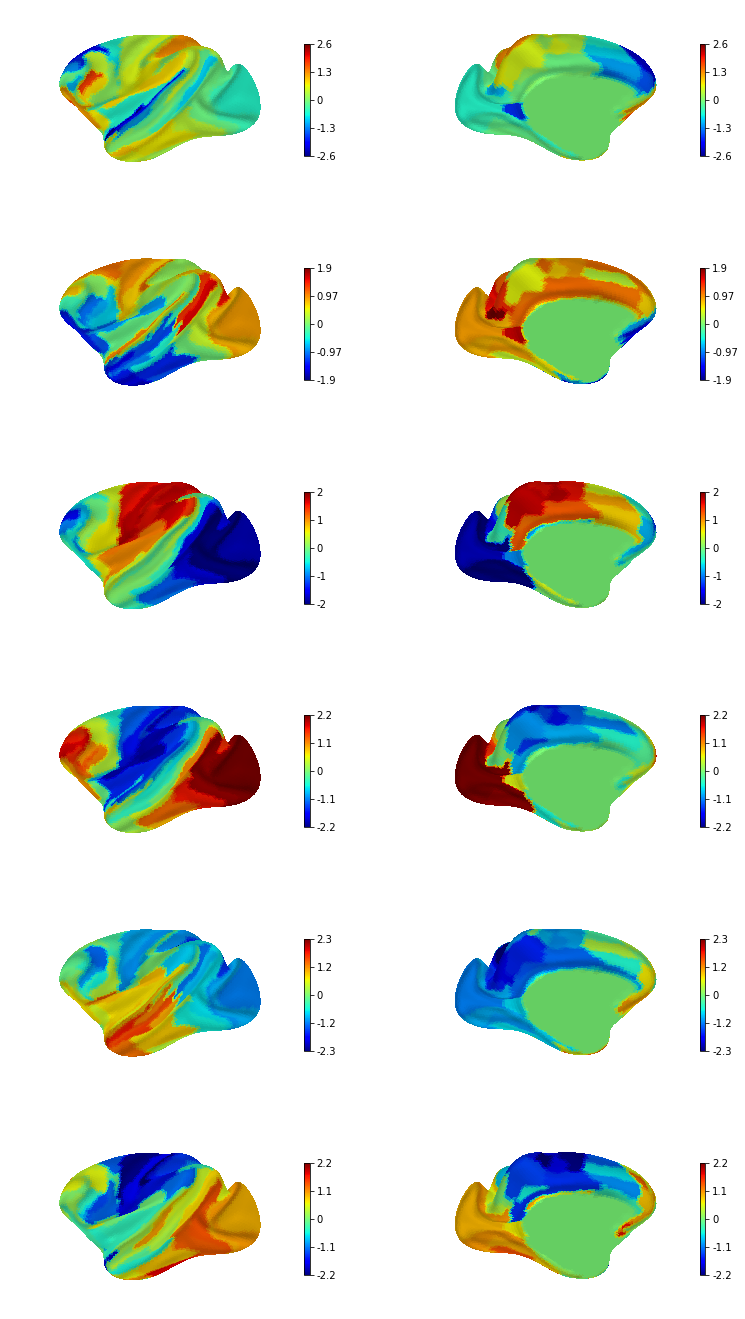

In [ ]:
%matplotlib inline
ROI_Limg = nib.load('/gdrive/My Drive/CMI/Project/MGCX/NHP/data/standard_mesh_atlases/L.atlasroi.10k_fs_LR.shape.gii')
L_imagemask = np.array(ROI_Limg.darrays[0].data)
ROI_Rimg = nib.load('/gdrive/My Drive/CMI/Project/MGCX/NHP/data/standard_mesh_atlases/R.atlasroi.10k_fs_LR.shape.gii')
R_imagemask = np.array(ROI_Rimg.darrays[0].data)
LR_mask = []
LR_mask = np.append([L_imagemask],[R_imagemask], axis=1)

parcel_label = '/gdrive/My Drive/CMI/Project/MGCX/NHP/data/10k_Markov182/R.MarkovCC12_M132_91-area.10k_fs_LR.dlabel.nii'
# rsurf = surface.load_surf_mesh('%s/fsaverage_LR10k/MAJOM.R.inflated.10k_fs_LR.surf.gii' % wdir)
lsurf = surface.load_surf_mesh('%s/fsaverage_LR10k/MAJOM.L.inflated.10k_fs_LR.surf.gii' % wdir)
# lsurf = surface.load_surf_mesh('%s/fsaverage_LR10k/MAJOM.R.curvature.10k_fs_LR.shape.gii'% wdir)


L_data_mask = np.where(L_imagemask == 1)  
vmat10k_append = []
for i in range(n_clusters):
  data_LR_diagonal = Z_all[i].reshape(1,182)[:,91:182]
  vmat10k = np.zeros([10242])
  vmat10k[L_data_mask] = parcel2vert_all(wdir,lsurf,parcel_label,data_LR_diagonal)
  vmat10k_append.append(vmat10k)



cmap = 'jet' 

# fig = plt.figure(figsize=(13,20))
# for i in range(1): 
#   ax = plt.subplot(5,2,2*i+1, projection='3d')
#   pmc = plotting.plot_surf(lsurf,vmat10k_append[i], bg_map=None, hemi='left',view = 'lateral', cmap = cmap, colorbar = False, labelsize=100,  vmin = vmin, vmax = vmax, avg_method = 'median', alpha = 1, darkness = 1, symmetric_cmap=False,axes=ax)#title='ISO-'+isolevel_con[i],
#   ax = plt.subplot(5,2,2*i+2, projection='3d')
#   pmc = plotting.plot_surf(lsurf, vmat10k_append[i], bg_map=None, hemi='left',view = 'medial', cmap = cmap, colorbar = True, colorbar_fontsize=200, vmin = vmin, vmax = vmax, avg_method = 'median', alpha = 1, darkness = 1, symmetric_cmap=False,axes=ax) #title='ISO-'+isolevel_con[i],
 


surf_map ='%s/fsaverage_LR10k/MAJOM.L.inflated.10k_fs_LR.surf.gii' % wdir
bg_map = "/gdrive/My Drive/CMI/Project/MGCX/NHP/fsaverage_LR10k/lh.MacaqueYerkes19.curvature.10k_fs_LR.nii.gz"



threshold=None  #T-scores > 7
figure_size_y = 4*n_clusters
fig = plt.figure(figsize=(13,figure_size_y))
for i in range(n_clusters): 
  ax = plt.subplot(n_clusters,2,2*i+1, projection='3d')
  pmc = plotting.plot_surf_stat_map(surf_map, stat_map=vmat10k_append[i],hemi='left', view='lateral', colorbar=True,
                             bg_map=bg_map, bg_on_data=True,cmap='jet',threshold=threshold,axes=ax, darkness = 0.4)
  ax = plt.subplot(n_clusters,2,2*i+2, projection='3d')
  pmc = plotting.plot_surf_stat_map(surf_map, stat_map=vmat10k_append[i],hemi='left', view='medial', colorbar=True,
                             bg_map=bg_map, bg_on_data=True,cmap='jet',threshold=threshold,axes=ax,darkness = 0.4)


# plt.tight_layout()
plt.show()

# matching cluster

In [ ]:
filename = "/gdrive/My Drive/CMI/Project/NHP/monkey_pca_sharing/k-means/centroids_output/Cent_inert_lab_dist_Concentration-000_clean_rerun_k-15.pkl" 

pickle_in = open(filename,"rb")
results = np.asarray(pickle.load(pickle_in))

n_clusters = 12
labels = []
for i in range(n_clusters+1):
  labels.append(results[:,i][2])
  
print(results.shape)
print(np.max(results[:,12][2]))

(4, 13)
13


In [ ]:
results[:,n_clusters][0].shape

(14, 26442, 1)

In [ ]:
# centroids,inertia,labels,dist
n_clusters = 10
centroids = results[:,n_clusters][0]
inertia = results[:,n_clusters][1]
labels = results[:,n_clusters][2]
dist = results[:,n_clusters][3]
np.max(labels)

11

In [ ]:
np.max(results[:,12][2])

13

In [ ]:
np.max(labels[-1])

13

In [ ]:
print(np.min(labels))
np.max(labels)


0


13

In [ ]:
results[:,10][0].shape

(12, 26442, 1)

In [ ]:
# filename = "/gdrive/Shared with me/Sharing/Cent_inert_lab_dist_Concentration-000_clean_rerun_k-15.pkl" 

data_pkl = "/gdrive/My Drive/CMI/Project/NHP/monkey_pca_sharing/k-means/Data_clean_rerun.pkl" 

with open(data_pkl, 'rb') as pkl_file:
    all_data,all_tcs,tr,psize = pickle.load(pkl_file)


In [ ]:
all_tcs['iso_000'].shape

(2880, 26442)

In [ ]:
labels

[array([1, 1, 1, ..., 0, 0, 0]),
 array([1, 1, 1, ..., 2, 2, 2]),
 array([3, 3, 3, ..., 2, 2, 2]),
 array([3, 3, 3, ..., 2, 2, 2]),
 array([1, 1, 1, ..., 2, 2, 2]),
 array([1, 1, 3, ..., 2, 2, 2]),
 array([1, 1, 1, ..., 6, 6, 6]),
 array([8, 8, 8, ..., 6, 6, 6]),
 array([8, 8, 8, ..., 6, 6, 6]),
 array([8, 8, 8, ..., 6, 6, 6]),
 array([8, 8, 8, ..., 6, 6, 6]),
 array([8, 8, 8, ..., 6, 6, 6]),
 array([8, 8, 8, ..., 6, 6, 6])]

### get CAP - use mean 

In [ ]:
from scipy import stats 
klabels = labels
n_clusters = 12
isolevel = '000'
data_stack = all_tcs["iso_{0}".format(isolevel)] 
cap_all_append_concs = []

for cluster_i in range(n_clusters+1): 
  cap_append = []
  for i in range(cluster_i+2): #once we did the kmeans on the data stack (cat all sessions) we go through each cluster and average the time courses of each cap
    cluster_mask = np.where(klabels[cluster_i] == i)

    avg_voxel= np.mean(data_stack[cluster_mask],axis=0)

    # z-score
    Z = zscore(avg_voxel)

    TnPvals = stats.ttest_1samp(avg_voxel,Z,axis=0)

    TnPvals = np.array(TnPvals)
    T =  TnPvals[0,:]

    cap_append.append(T)

  cap_all = np.vstack(cap_append)  
  cap_all_append_concs.append(cap_all)
print(np.array(cap_all_append_concs).shape)

(13,)


In [ ]:
cap_all_append_concs

[array([[-24.60742381, -23.74582104, -28.77627541, ..., -21.99258177,
         -22.36371059, -22.73826285],
        [-26.39450973, -26.21543472, -27.25632191, ..., -25.86109515,
         -25.93647726, -26.01259751]]),
 array([[ -17.62955343,  -17.48800498,  -18.16723941, ...,  -17.51890882,
          -17.52426068,  -17.53101911],
        [ -17.60499371,  -17.58777056,  -17.82983591, ...,  -17.24610874,
          -17.30699811,  -17.36714436],
        [ 517.56890523,  731.63546107, -509.85496325, ..., 1149.17302957,
         1060.11453736,  970.15769152]]),
 array([[-17.72499225, -17.57992803, -18.27687307, ..., -17.60981523,
         -17.61560985, -17.62284171],
        [-17.44071166, -17.39724814, -17.97659234, ..., -16.60379907,
         -16.74545402, -16.88541896],
        [-12.75512469,  -8.19149568, -30.13135486, ...,  -8.99136092,
          -9.20149295,  -9.45551704],
        [-23.87105233, -23.77280593, -24.45472638, ..., -23.33820487,
         -23.42145021, -23.50446475]]),
 arr

## hungarian matching

In [ ]:
#hungarian matching
from scipy.optimize import linear_sum_assignment

In [ ]:
#correlation function
def correlation(matrix1, matrix2): #using correlation function Jae gave me from (Alex or Annibal forgot which one)
    d1 = matrix1.shape[-1]
    d2 = matrix2.shape[-1]
    assert d1 == d2
    assert matrix1.ndim <= 2
    assert matrix2.ndim <= 2
    matrix1 = zscore(matrix1.astype(float), matrix1.ndim - 1) / np.sqrt(d1)
    matrix2 = zscore(matrix2.astype(float), matrix2.ndim - 1) / np.sqrt(d2)
    if matrix1.ndim >= matrix2.ndim:
        return np.dot(matrix1, matrix2.T)
    else:
        return np.dot(matrix2, matrix1.T)
## Hecheng Parcel to Vertex functions 


#fixing to save out reordered labels
#function to remap labels (should be above technically)
def remap(a, val_old, val_new):
    df = pd.Series(a, dtype=val_new.dtype)
    d = dict(zip(val_old, val_new))
    return df.map(d).values
#all_pkl = outpath + "/All_kmeans_vars_first_loop_%s.pkl" % (trial)

In [ ]:
# map k to k+1

cond_len = np.array(np.shape(cap_all_append_concs)[0])
concentrations = ['000','075','100','150','200']
b = 0
reordered_cap_all_concs = []
new_list_append = []
old_list_append = []
all_remapped_labels = []
reordered_centroids = []
#cond_len is pretty much the lenght of how many conditions you have
reordered_labels = []

labels = np.array(labels) # to make it consistent with the following code. 

for a in range(n_clusters): #looping through the cluster numbers 
    b = b+1 #getting the ix of k+1
    if a == 0: #since we are using the reordered k from the second iteration on, this gets out K1 and then for the rest it will use the reordered version 
        print("this is the first iteration")
        k_a = cap_all_append_concs[a] #get out the first set of CAP
        reordered_centroids.append(k_a)  #append this to the final variable with all reordered in it. 
        curr_labels_b = labels[b,:] #get out the first set of centroids
        print("orig labels A")
        print(curr_labels_b[0:20])
        remapped_labels = curr_labels_b
        reordered_labels.append(remapped_labels)

    else:
        k_a = k_Bord  #if its the second time around, use the reordered centroids set for ka which were reordered before

    curr_labels_b = labels[b,:]
    print("orig labels B")
    print(curr_labels_b[0:20])
    k_B = cap_all_append_concs[b] #get the k+1 centroids to compare to the previous option
    #making first K centroids matrix same size as second by padding it with zeros
    ak = np.shape(k_a)[0]
    av = np.shape(k_a)[1]
    k_A = np.zeros((ak+1,av)) #add row of zeros to end of k shape 
    k_A[:-1,:] = k_a

    refXin = 1- correlation(k_A,k_B) #get the 1-correlation distance matrix between K and K+1

    NaN_ix = np.isnan(refXin)
    refXin[NaN_ix] = 0 #replace NaNs for the final row where we padded it with zeros. 
    #reordering with hungarian matching
    cost = np.array(refXin) #convert to np. array
    row_ind, col_ind = linear_sum_assignment(cost) #do hungarian matching on this cost matrix getting out the row and column indices
    cost[row_ind, col_ind].sum()
    col_realnum = col_ind + 1 #doing this for plotting purposes
    colist = ["%02d" % x for x in col_realnum]  
    reordered_image = cost[:,col_ind][row_ind] #reorder 1-correlation matrix
    reordered_image2 = reordered_image[0:-1,0:-1] #take away the last row where its correlating Kn with the padded zeros

    k_Bord = k_B[col_ind,:] #reorder initial K 

    reordered_centroids.append(k_Bord) #append this to the reordered centroids variable 
    #print("row and column")
    print(row_ind)
    print(col_ind) #wanna use col
    remapped_labels = remap(curr_labels_b, row_ind, col_ind) #new
    reordered_labels.append(remapped_labels) #new reordered_labels
    print("Reordered labels")
    print(remapped_labels[0:20])


this is the first iteration
orig labels A
[1 1 1 1 1 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2]
orig labels B
[1 1 1 1 1 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2]
[0 1 2]
[1 2 0]
Reordered labels
[2 2 2 2 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
orig labels B
[3 3 3 3 3 3 3 0 2 2 2 2 2 2 2 2 2 1 1 2]
[0 1 2 3]
[1 3 0 2]
Reordered labels
[2 2 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 3 3 0]
orig labels B
[3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 4 4 4]
[0 1 2 3 4]
[1 3 2 0 4]
Reordered labels
[0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 4 4 4]
orig labels B
[1 1 1 3 3 3 3 2 2 2 2 2 2 2 2 2 4 4 4 4]
[0 1 2 3 4 5]
[1 5 0 2 4 3]
Reordered labels
[5 5 5 2 2 2 2 0 0 0 0 0 0 0 0 0 4 4 4 4]
orig labels B
[1 1 3 3 3 3 3 2 2 2 2 2 2 2 4 4 4 4 4 4]
[0 1 2 3 4 5 6]
[1 5 0 2 4 3 6]
Reordered labels
[5 5 2 2 2 2 2 0 0 0 0 0 0 0 4 4 4 4 4 4]
orig labels B
[1 1 1 4 4 4 0 3 3 3 3 3 3 2 2 2 2 2 2 7]
[0 1 2 3 4 5 6 7]
[1 7 0 6 2 4 3 5]
Reordered labels
[7 7 7 2 2 2 1 6 6 6 6 6 6 0 0 0 0 0 0 5]
orig labels B
[8 8 8 8 8 8 8 3 3 3 3 3 3 2 2 2 2 2 2 7]
[0 1 2 3 4 5 6

In [ ]:
#finishing off abover loop to reorder mean maps
#label_concs.append(labels)
cond_len = np.array(np.shape(cap_all_append_concs)[0])
concentrations = ['000','075','100','150','200']
b = 0
reordered_cap_all_concs = []
new_list_append = []
old_list_append = []
all_remapped_labels = []
#cond_len is pretty much the lenght of how many conditions you have
for a in range(cond_len):
    b = b+1 #getting the ix of k+1
    print(b)
    isolevel = concentrations[a]

    data_stack = all_tcs["iso_{0}".format(isolevel)] 

    if a == 0: #since we are using the reordered k from the second iteration on, this gets out K1 and then for the rest it will use the reordered version 
        print("this is the first iteration")
        cond_a = np.squeeze(cap_all_append_concs[a]) #get out the first set of centroids
        reordered_cap_all_concs.append(cond_a)
        rowlist = list(range(0, len(cond_a)))
        new_list_append.append(rowlist)
        old_list_append.append(rowlist)
        #reordering labels
        #curr_labels = np.squeeze(labels_concs[a]) #ADDING LABEL REORDER
        #remapped_labels = curr_labels #ADDING LABEL REORDER
        #print('THIS original remapped %s' % a)
        #print(remapped_labels[0:940])
        #all_remapped_labels.append(remapped_labels)
        #print(test)
 
    else:
        cond_b = np.squeeze(cap_all_append_concs[a])
        #curr_labels = np.squeeze(labels_concs[a]) #ADDING LABEL REORDER
        #print("orig labels")#ADDING LABEL REORDER
        #print(curr_labels[0:240])#ADDING LABEL REORDER
        refXin = 1- correlation(cond_a,cond_b) #get the 1-correlation distance matrix between K and K+1
        #print(np.shape(refXin))
        NaN_ix = np.isnan(refXin)
        refXin[NaN_ix] = 0
        cost = np.array(refXin) #convert to np. array
        row_ind, col_ind = linear_sum_assignment(cost) #do hungarian matching on this cost matrix getting out the row and column indices
        cost[row_ind, col_ind].sum()
        col_realnum = col_ind + 1 #doing this for plotting purposes
        colist = ["%02d" % x for x in col_realnum]
        row_realnum = row_ind + 1 #doing this for plotting purposes
        rowlist = ["%02d" % x for x in row_realnum]
        new_list_append.append(rowlist)
        old_list_append.append(colist)
        #print(rowlist)
        print(row_ind)  
        print(col_ind) #use this to reorder to new order
  
        reordered_image = cost[:,col_ind][row_ind] #reorder 1-correlation matrix

        cond_Bord = cond_b[col_ind,:] #reorder initial K 
        reordered_cap_all_concs.append(cond_Bord) #append this to the reordered centroids variable 
        #remapped_labels = remap(curr_labels, row_ind, col_ind) #ADDING LABEL REORDER
        #print('THIS remapped %s' % a)
       # print(remapped_labels[0:240])
        #all_remapped_labels.append(remapped_labels) #ADDING LABEL REORDER
    print(np.shape(reordered_cap_all_concs))
    #print(np.shape(all_remapped_labels))

1
this is the first iteration
(1, 12, 26442)
